**1. 출력될 3개를 순서대로  쓰시오.**

In [1]:
import sys
sys.path.append('C://Users//HAN//Documents//Deep Learning from Scratch 2') # 각자의 경로로 수정해주세요.
import numpy as np
import collections
from common.util import preprocess

전처리 먼저 하죠.

In [2]:
text = 'The sky is very blue and the sky is very beautiful today.'
corpus, word_to_id, id_to_word = preprocess(text)

Counter 클래스를 이용해서 키를 어휘 id로 가지고 밸류를 어휘 등장 회수로 가지는 딕셔너리를 만듭니다.

In [3]:
counts = collections.Counter()
for word_id in corpus:
    counts[word_id] += 1
print(counts)

Counter({0: 2, 1: 2, 2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1})


샘플링을 위해 어휘들 위의 확률분포를 만들어 보죠.  
인덱스가 어휘의 id이고 값이 어휘의 등장회수인 리스트를 만듭니다.  
원래는 0.75승을 해서 등장빈도가 적은 어휘의 확률을 올리는 보정작업을 거치는데 손으로 계산하기 위해 제곱을 해줬습니다.  
제곱은 등장회수가 적은 어휘와 등장회수가 많은 어휘의 확률 차이를 오히려 더 커지게 하는데 계산의 편의를 위해 어쩔수 없네요.

In [4]:
vocab_size = len(word_to_id)
word_p = np.zeros(vocab_size)
for i in range(vocab_size):
    word_p[i] = counts[i]
word_p = np.power(word_p, 2)
print(word_p)

[4. 4. 4. 4. 1. 1. 1. 1. 1.]


최종적으로 노멀라이즈를 해서 확률분포를 만듭니다.  
다시말해, 합 21로 나눠줍니다.

In [5]:
word_p /= np.sum(word_p)
print(word_p)

[0.19047619 0.19047619 0.19047619 0.19047619 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]


시험지에는 $4 \over 21$와 $1 \over 21$로 써줍시다.

In [6]:
print(4/21)
print(1/21)

0.19047619047619047
0.047619047619047616


**2. 입력층 가중치 행렬 $W_{\rm in}$과 출력층 가중치 행렬 $W_{\rm out}$이
$$
W_{\rm in} =
\begin{pmatrix}
1&2&3\\
2&3&4\\
3&4&5\\
4&5&6\\
5&6&7\\
6&7&8\\
7&8&9
\end{pmatrix},
\qquad
W_{\rm out} =
\begin{pmatrix}
0&-{1 \over 2}\log2&-\log2&2\log2&2\log2&2\log2&2\log2\\
-\log 2&-{1 \over 3}\log2&\log2&0&0&0&0\\
\log 2&\log2&0&-\log2&-\log2&-\log2&-\log2\\
\end{pmatrix}
$$
인 다음과 같은 CBOW 모델을 생각하자.
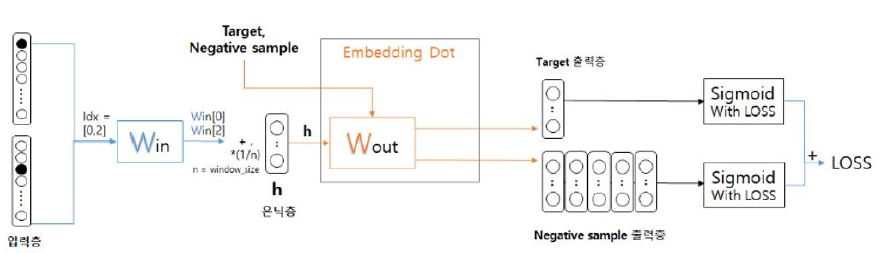
첫번째 context인 (you, goodbye)를 입력하고 negative sampling한 세 단어가  you와 I와 hello이다.**

**(i) 은닉벡터 $h$, 스코어 $s$, 손실함수 값 $L$을 구하시오.**

컨텍스트 you와 goodbye를 각각 Embedding층을 통과시키면 입력 가중치 행렬 $W_{\rm in}$의 0번째 행과 2번째행을 뽑아서 $[1,2,3]$과 $[3,4,5]$이 나오게 됩니다.  
은닉층에서는 이 둘을 평균하여 은닉벡터
$$
h = {1 \over 2}\left((1,2,3)+(3,4,5)\right) = (2,3,4)
$$
을 만들어냅니다.

스코어를 만들기 위해 은닉벡터 $h$를 네개의 Embedidng Dot층에 통과시킵니다.  
타겟이 say이고 네거티브 샘플링한 단어가 you, I, hello이므로 가중치 행렬 $W_{\rm out}$의 1열, 0열, 4열, 5열을 뽑아내어 은닉벡터 $h$와 내적합니다.  
스코어는
$$
\begin{aligned}
{\rm say :}& \quad [2,3,4]\circ[-{1 \over 2}\log2,-{1 \over 3}\log2,\log2] = 2\log2 \\
{\rm you :}& \quad [2,3,4]\circ[0,-\log2,\log2] = \log2 \\
{\rm I :}& \quad [2,3,4]\circ[2\log2,0,-\log2] = 0 \\
{\rm hello :}& \quad [2,3,4]\circ[2\log2,0,-\log2] = 0 \\
\end{aligned}
$$
입니다.

시그모이드 함수를 취하면 4개의 어휘에 대해 신경망이 추측한 확률
$$
\begin{aligned}
{\rm say :}& \quad {1 \over 1+e^{-2\log2}} = {1 \over 1+1/4} = {4 \over 5}\\
{\rm you :}& \quad {1 \over 1+e^{-\log2}} = {1 \over 1+1/2} = {2 \over 3}\\
{\rm I :}& \quad {1 \over 1+e^0} = {1 \over 1+1} = {1 \over 2}\\
{\rm hello :}& \quad {1 \over 1+e^0} = {1 \over 1+1} = {1 \over 2}
\end{aligned}
$$
을 구할수 있습니다.  
확률벡터 형태로 쓰면
$$
({1 \over 5}, {4 \over 5}),\quad ({1 \over 3}, {2 \over 3}),\quad ({1 \over 2}, {1 \over 2}),\quad ({1 \over 2}, {1 \over 2})
$$
입니다.

say는 타겟이서 라벨이 1이고 you, I, hello는 네거티브 샘플링한 단어라서 라벨이 0입니다.  
따라서, 각각의 교차 엔트로피값은
$$
\begin{aligned}
{\rm say :}& \quad -\log{4 \over 5} = \log{5 \over 4}\\
{\rm you :}& \quad -\log{1 \over 3} = \log 3\\
{\rm I :}& \quad -\log{1 \over 2} = \log 2\\
{\rm hello :}& \quad -\log{1 \over 2} = \log 2
\end{aligned}
$$
입니다.  
모두 더해서 최종 손실함수 값
$$
L = \log{5 \over 4} + \log 3 + \log 2 + \log 2 = \log 15
$$
을 얻습니다.

**(ii) 미분
$$
{\partial L \over \partial s}, \qquad {\partial L \over \partial h},\qquad {\partial L \over \partial W_{\rm out}}, \qquad {\partial L \over \partial W_{\rm in}}
$$
을 구하시오.**

스코어에 대한 미분은 SigmoidWithLoss층 역전파
$$
{\partial L \over \partial s} = y-t
$$
에 의해 주어집니다.  
(SoftmaxWithLoss층 역전파도 $y-t$로 주어지는데 기호는 같지만 의미가 다릅니다. SoftmaxWithLoss층 역전파에서는 $y$가 확률벡터이고 $t$가 라벨의 원 핫 인코딩인데 반해 SigmoidWithLoss층 역전파에서는 $y$와 $t$가 모두 스칼라입니다.)  
말로 풀면 확률 빼기 라벨입니다.  
공식을 이용해 스코어에 대한 미분을 구하면
$$
\begin{aligned}
{\rm say :}& \quad{4 \over 5}-1 = -{1 \over 5}\\
{\rm you :}& \quad {2 \over 3}-0 = {2 \over 3}\\
{\rm I :}& \quad {1 \over 2}-0 = {1 \over 2}\\
{\rm hello :}& \quad {1 \over 2}-0 = {1 \over 2}
\end{aligned}
$$
이 나오네요.

Embedding dot층의 계산 그래프는 다음과 같습니다.
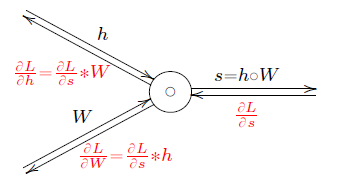
$*$는 스칼라 곱이고 $\circ$는 내적입니다.  
이 문제에서는 배치처리를 하지 않으므로 $\partial L \over \partial s$은 스칼라이고 $W$는 행벡터입니다.  
네 단어에 대해  $\partial L \over \partial s$는 방금 구했고 $W$는 $W_{\rm out}$에서 1열, 0열, 4열, 5열을 뽑아낸 벡터입니다.

공식
$$
{\partial L \over \partial h}={\partial L \over \partial s}*W
$$
을 적용해 각 단어의 은닉벡터에 대한 미분을 구하면
$$
\begin{aligned}
{\rm say :}& \quad -{1 \over 5} * [-{1 \over 2}\log2,-{1 \over 3}\log2,\log2] = [{1 \over 10}\log2,{1 \over 15}\log2,-{1 \over 5}\log2] \\
{\rm you :}& \quad {2 \over 3}*[0,-\log2,\log2] = [0,-{2 \over 3}\log2,{2 \over 3}\log2] \\
{\rm I :}& \quad {1 \over 2}*[2\log2,0,-\log2] = [\log2,0,-{1 \over 2}\log2] \\
{\rm hello :}& \quad {1 \over 2}*[2\log2,0,-\log2] = [\log2,0,-{1 \over 2}\log2]
\end{aligned}
$$
이 됩니다.  
네거티브 샘플링을 할때는 은닉벡터가 사실 여러개의 Embedding Dot층으로 복사해서 들어가게 됩니다.  
다시말해, Embedding Dot층 직전에 repeat 노드가 암묵적으로 숨어있는 것이지요. repeat 노드의 역전파는 sum입니다.  
따라서, 은닉벡터에 대한 미분은 위 네 미분을 모두 합쳐
$$
{\partial L \over \partial h}=[{21 \over 10}\log2,-{3 \over 5}\log2,-{8 \over 15}\log2]
$$
이 됩니다.

공식
$$
{\partial L \over \partial W}={\partial L \over \partial s}*h
$$
을 적용해 $W$에 대한 미분을 구하면
$$
\begin{aligned}
{\rm say :}& \quad -{1 \over 5} * [2,3,4] = [-{2 \over 5},-{3 \over 5},-{4 \over 5}] \\
{\rm you :}& \quad {2 \over 3}*[2,3,4] = [{4 \over 3},2,{8 \over 3}] \\
{\rm I :}& \quad {1 \over 2}*[2,3,4] = [1,{3 \over 2},2] \\
{\rm hello :}& \quad {1 \over 2}*[2,3,4] = [1,{3 \over 2},2] \\
\end{aligned}
$$
이 됩니다.  
$W$는 $W_{\rm out}$을 tranpose한후 embedding층을 통과시켜 얻어진 행렬입니다.  
따라서 역전파는 위에서 구한 $W$에 대한 미분들을 영행렬의 해당 열에 집어 넣는 작용입니다.  
출력 가중치 행렬에 대한 미분은
$$
{\partial L \over \partial W_{\rm out}} =
\begin{pmatrix}
{4 \over 3}&-{2 \over 5}&0&0&1&1&0\\
2&-{3 \over 5}&0&0&{3 \over 2}&{3 \over 2}&0\\
{8 \over 3}&-{4 \over 5}&0&0&2&2&0
\end{pmatrix}
$$
와 같습니다.

마지막으로 $\partial L \over \partial W_{\rm in}$은 embedding층의 역전파에 의해 얻어집니다.  
가중치 행렬를 공유하는 두개의 embedding층으로 흘러들어온 미분 $\partial L \over \partial h$을 you에 해당하는 0행에 집어넣고 goodbye에 해당하는 2행에도 역시 집어 넣어
$$
{\partial L \over \partial W_{\rm in}} =
{1 \over 2}
\begin{pmatrix}
{21 \over 10}\log2&-{3 \over 5}\log2&-{8 \over 15}\log2\\
0&0&0\\
{21 \over 10}\log2&-{3 \over 5}\log2&-{8 \over 15}\log2\\
0&0&0\\
0&0&0\\
0&0&0\\
0&0&0
\end{pmatrix}
$$
을 얻습니다.  
앞에 $1 \over 2$이 곱해져 있는 이유는 순전파때 평균을 했기때문입니다.

(iii) Embedding 클래스, EmbeddingDot 클래스, SigmoidWithLoss 클래스의 인스턴스를 만들어 검산하시오.

In [7]:
from common.layers import Embedding, SigmoidWithLoss
from ch04.negative_sampling_layer import *

context를 입력할 Embedding층 인스턴스 2개를 만들겠습니다.

In [8]:
W_in = np.array([[1.,2.,3.],[2.,3.,4.],[3.,4.,5.],[4.,5.,6.],[5.,6.,7.],[6.,7.,8.],[7.,8.,9.]])

Embedding1=Embedding(W_in)
Embedding2=Embedding(W_in)

you와 goodbye를 넣고 Embedding 클래스 순전파 메서드를 적용후 평균하여 은닉벡터를 구합니다.  
교재코드는 배치처리를 염두해두고 작성되었기 때문에 데이터 하나를 넣더라도 1개짜리 배치묶음이라 생각하고 `[0]`, `[2]`와 같이 브라켓을 씌워줍니다.

In [9]:
h=(Embedding1.forward([0])+Embedding2.forward([2]))/2
print(h)

[[2. 3. 4.]]


Embedding dot층 인스턴스 4개를 만듭니다.  
하나는 타겟용이고 세개는 네거티브 샘플용입니다.  
인스턴스를 만들때 $W_{\rm out}$을 transpose후 인수로 입력합니다.

In [10]:
W_out = np.array([[0,-np.log(2)/2,-np.log(2),2*np.log(2),2*np.log(2),2*np.log(2),2*np.log(2)],
                   [-np.log(2),-np.log(2)/3,np.log(2),0,0,0,0],
                   [np.log(2),np.log(2),0,-np.log(2),-np.log(2),-np.log(2),-np.log(2)]])

ED1=EmbeddingDot(W_out.T)
ED2=EmbeddingDot(W_out.T)
ED3=EmbeddingDot(W_out.T)
ED4=EmbeddingDot(W_out.T)

Embedding Dot 클래스 순전파 메서드로 4개의 스코어를 구합니다.

In [11]:
s1=ED1.forward(h,[1])
s2=ED2.forward(h,[0])
s3=ED3.forward(h,[4])
s4=ED4.forward(h,[5])
print(s1,s2,s3,s4)

[1.38629436] [0.69314718] [0.] [0.]


손계산 결과와 일치하는지 확인해보죠.

In [12]:
print(2*np.log(2),np.log(2))

1.3862943611198906 0.6931471805599453


SigmoidWithLoss층 인스턴스 4개를 만듭니다.  
하나는 타겟용이고 세개는 네거티브 샘플용입니다.

In [13]:
L1=SigmoidWithLoss()
L2=SigmoidWithLoss()
L3=SigmoidWithLoss()
L4=SigmoidWithLoss()

타겟은 라벨이 1이고 네거티브 샘플들은 라벨이 0입니다.  
SigmoidWithLoss 클래스 순전파 메서드로 각각의 교차엔트로피 값을 얻습니다.  
모두 더하면 최종 손실함수 값이 됩니다.

In [14]:
l1=L1.forward(s1,np.array([1]))
l2=L2.forward(s2,np.array([0]))
l3=L3.forward(s3,np.array([0]))
l4=L4.forward(s4,np.array([0]))

loss=l1+l2+l3+l4

print(loss)

2.708049376102303


손계산 결과와 일치하는지 확인해보죠.

In [15]:
print(np.log(15))

2.70805020110221


이제 역전파를 시작해보죠.  
SigmoidWithLoss 클래스 역전파 메서드로 스코어에 대한 미분을 구합니다.

In [16]:
ds1=L1.backward()
ds2=L2.backward()
ds3=L3.backward()
ds4=L4.backward()

print(ds1,ds2,ds3,ds4)

[-0.2] [0.66666667] [0.5] [0.5]


Embedding Dot 클래스 역전파 메서드로 네개의 은닉 벡터에 대한 미분을 구합니다.  
은닉 벡터가 Embedding Dot층으로 카피되서 들어갔기 때문에 역전파는 더합니다.

In [17]:
dh1=ED1.backward(ds1)
dh2=ED2.backward(ds2)
dh3=ED3.backward(ds3)
dh4=ED4.backward(ds4)

dh=dh1+dh2+dh3+dh4

print(dh)

[[ 1.45560908 -0.41588831 -0.3696785 ]]


손계산 결과와 일치하는지 확인해보죠.

In [18]:
print(2.1*np.log(2),-0.6*np.log(2),-(8/15)*np.log(2))

1.4556090791758851 -0.4158883083359672 -0.36967849629863747


Embedding Dot 클래스는 $W_{\rm out}$에 관한 미분을 인스턴스 변수 self.grads에 저장합니다.

In [19]:
dW_out = np.array(ED1.grads)+np.array(ED2.grads)+np.array(ED3.grads)+np.array(ED4.grads)

print(dW_out)

[[[ 1.33333333  2.          2.66666667]
  [-0.4        -0.6        -0.8       ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 1.          1.5         2.        ]
  [ 1.          1.5         2.        ]
  [ 0.          0.          0.        ]]]


Embedding 클래스 역전파 메서드로 $W_{\rm in}$에 관한 미분을 구합니다.  
Embedding 클래스는 $W_{\rm in}$에 관한 미분을 인스턴스 변수 self.grads에 저장합니다.

In [20]:
Embedding1.backward(dh)
Embedding2.backward(dh)

dW_in = 0.5*(np.array(Embedding1.grads) + np.array(Embedding2.grads))

print(dW_in)

[[[ 0.72780454 -0.20794415 -0.18483925]
  [ 0.          0.          0.        ]
  [ 0.72780454 -0.20794415 -0.18483925]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]


손계산 결과와 일치하는지 확인해보죠.

In [21]:
print((21/20)*np.log(2),-0.3*np.log(2),-(8/30)*np.log(2))

0.7278045395879426 -0.2079441541679836 -0.18483924814931874
